In [1]:
# Basic dependencies:
import  numpy as np
import  matplotlib.pyplot as plt


In [2]:
# load the packages being tested:
import bms

from bms.parts import *
from nav.coordinates import *


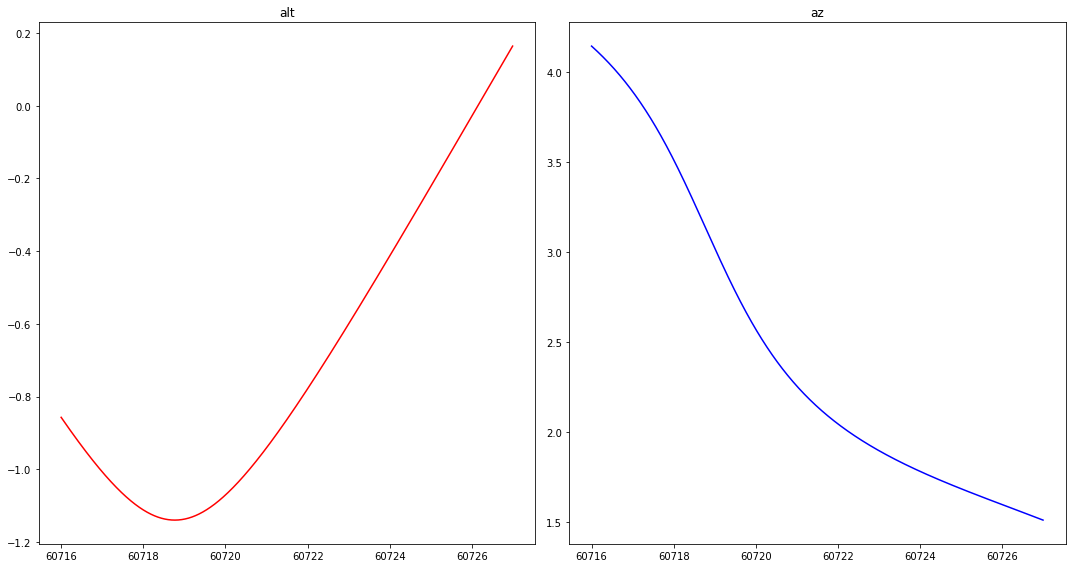

In [20]:
# test mjd
import lusee
import numpy as np
from lusee import Observation as O

fig, (p1, p2) = plt.subplots(1,2)

interval = "2025-02-10 00:00:00 to 2025-02-20 23:45:00"
o = O(interval)

(alt, az) = o.get_track_solar('sun')

y = np.array(alt)

length = o.times.size

x = np.empty(length)

for i in range(length):
    x[i] = o.times[i].mjd

plt.rcParams["figure.figsize"] = [15., 8.]
plt.rcParams["figure.autolayout"] = True

p1.set_title("alt")
p1.plot(x, alt, color="red")

y = np.array(az)
p2.set_title("az")
p2.plot(x, az, color="blue")
plt.show()



Current directory: /home/maxim/projects/lusee/power/notebooks
Number of points: 8979


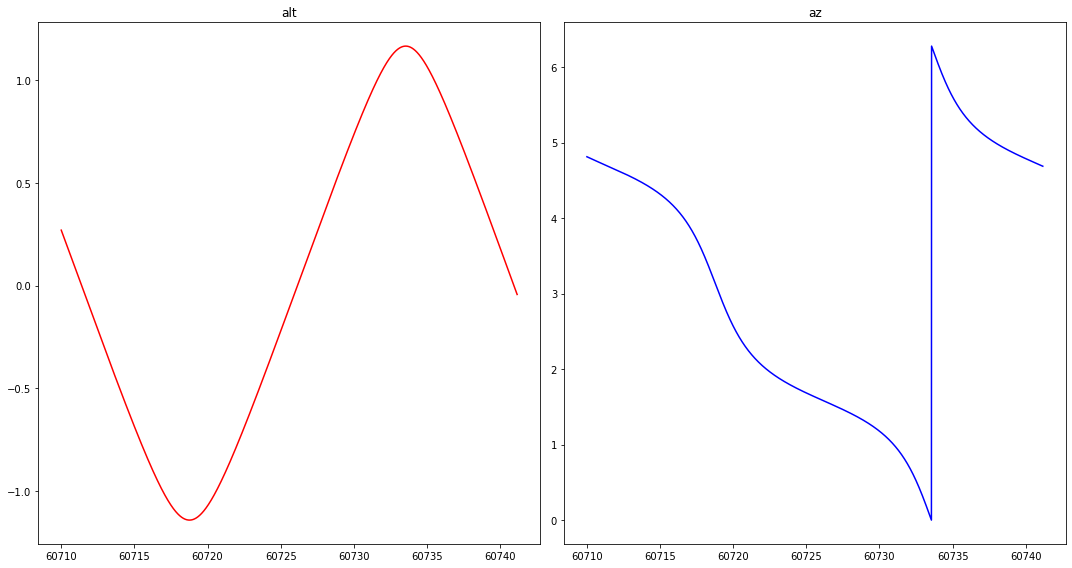

In [34]:
# Now testing with the prefab data
import os
print('Current directory:', os.getcwd())

cachefile = '../data/2025-02-04_03-07.npy'
with open(cachefile, 'rb') as f: mjd_alt_az = np.load(f)

print('Number of points:', mjd_alt_az.size)

mjd = mjd_alt_az[:,0]
alt = mjd_alt_az[:,1]
az  = mjd_alt_az[:,2]

fig, (p1, p2) = plt.subplots(1,2)

plt.rcParams["figure.figsize"] = [15., 8.]
plt.rcParams["figure.autolayout"] = True

p1.set_title("alt")
p1.plot(mjd, alt, color="red")

y = np.array(az)
p2.set_title("az")
p2.plot(mjd, az, color="blue")
plt.show()


In [ ]:
# using radians:

alt_sun_top = np.asarray(alt)+sun_rad

sun     = altaz2xyz(alt, az)
sun_top = altaz2xyz(alt_sun_top, az)

battery = Battery(11.6) 
print('Battery voltage:', battery.voltage)

ctr = Controller(battery)
print('Battery voltage from controller:', ctr.battery.voltage)

battery.set_voltage(10.1)
print('Battery voltage from controller:', ctr.battery.voltage)


e = EPanel(sun, 'E')
ctr.add_panel(e)

w = WPanel(sun, 'W')
ctr.add_panel(w)

t = TPanel(sun, 'T')
ctr.add_panel(t)

t_dot_sun_top = t.dot(sun_top)
t_dot_sun_top[t_dot_sun_top<0] = 0.0 # For finite disk at sunrise/sunset. Slight aprx: top of sun not center of segment

# fig, (p1, ) = plt.subplots(1,1)

plt.rcParams["figure.figsize"] = [15., 8.]
plt.rcParams["figure.autolayout"] = True

# p1.set_title("e_dot")
plt.plot(mjd, e.dot_sun, color="blue", label="E")
plt.plot(mjd, w.dot_sun, color="orange", label="W")
plt.plot(mjd, t.dot_sun, color="green", label="T")

tot = e.dot_sun + w.dot_sun + t.dot_sun

plt.plot(mjd, tot, color="black")

plt.grid(True)

#p2.set_title("w_dot")
#p2.plot(mjd, w_dot, color="blue")

plt.legend()

plt.show()

# Sanitize input to arccos and sqrt. Values where h<0 are non-physical and will be cut by condition_list.
#alt_seg = np.abs(alt)
#alt_seg[alt_seg>sun_rad]=sun_rad
#sun_seg_area = (sun_rad**2)*np.arccos(1-((sun_rad-alt_seg)/sun_rad))-alt_seg*np.sqrt((sun_rad**2)-(alt_seg)**2)
#sun_seg_frac = sun_seg_area/(np.pi*sun_rad**2)

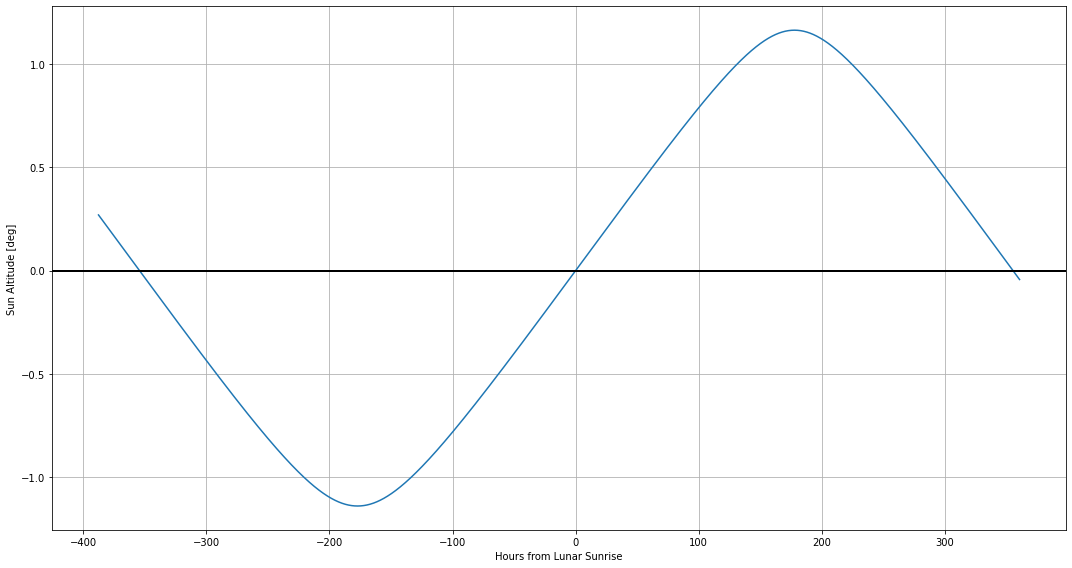

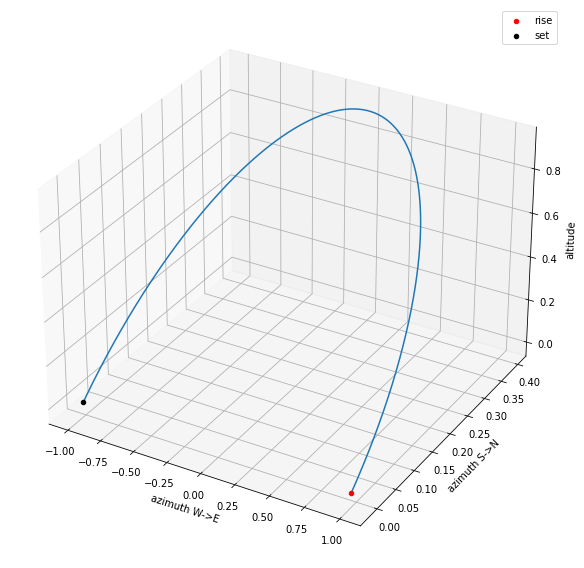

In [43]:
# transitions
iMidnight = np.argmin(alt)
iNoon = np.argmax(alt)
iSundown1 = np.argmin(np.abs(alt[:iMidnight]))
iSunrise = np.argmin(np.abs(alt[iMidnight:])) + iMidnight
iSundown2 = np.argmin(abs(alt[iNoon:])) + iNoon
hrsFromSunset = (mjd - mjd[iSundown1])*24
hrsFromSunrise = (mjd - mjd[iSunrise])*24

t_inc = 0.25 #Varies! But approx 0.25hrs ticks

alt_sun_top = np.asarray(alt)+0.265
iSuntoprise = np.argmin(np.abs(alt_sun_top[iMidnight:iNoon])) + iMidnight
iSuntopdown2 = np.argmin(abs(alt_sun_top[iNoon:])) + iNoon

# plot altitude through the cycle
plt.plot(hrsFromSunrise,alt, label='Alt')
plt.axhline(0, c='k', lw=2)
plt.grid(True)
plt.xlabel("Hours from Lunar Sunrise")
plt.ylabel("Sun Altitude [deg]")

# plot track of sun in 3D during 1 lunar day
plt.figure()
ax = plt.axes(projection='3d')
# day_mask = alt > 0
day_mask = [False]*len(alt) | (alt>0)
for i in range(len(day_mask)):
    if (i<iMidnight):
        day_mask[i] = False

sun = altaz2xyz(alt, az)
sunDay = altaz2xyz(alt, az)[day_mask]

ax.plot3D(sunDay[:,0],sunDay[:,1],sunDay[:,2])
ax.scatter3D(sunDay[0,0],sunDay[0,1],sunDay[0,2], c='r', label='rise')
ax.scatter3D(sunDay[-1,0],sunDay[-1,1],sunDay[-1,2], c='k', label='set')

ax.set_xlabel('azimuth W->E')
ax.set_ylabel('azimuth S->N')
ax.set_zlabel('altitude')
ax.legend()
